# Exercise 4: recommender System

In [1]:
#check if notebook runs in colab
import sys
IN_COLAB = 'google.colab' in sys.modules
print('running in Colab:',IN_COLAB)
path='..'
if IN_COLAB:
  #in colab, we need to clone the data from the repo
  !git clone https://github.com/keuperj/DataScienceSS20.git
  path='DataScienceSS20'

running in Colab: True
Cloning into 'DataScienceSS20'...
remote: Enumerating objects: 586, done.
remote: Total 586 (delta 0), reused 0 (delta 0), pack-reused 586
Receiving objects: 100% (586/586), 130.66 MiB | 12.80 MiB/s, done.
Resolving deltas: 100% (240/240), done.
Checking out files: 100% (219/219), done.


## Code from the lecture

In [3]:
#read data to DataFrames
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(path+'/DATA/movielens100k/u.user', sep='|', names=u_cols, encoding = "ISO-8859-1")

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(path+'/DATA/movielens100k/u.data', sep='\t', names=r_cols, encoding = "ISO-8859-1")

m_cols=['movie_id', 'title', 'release date', 'video release date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv(path+'/DATA/movielens100k/u.item', sep='|', names=m_cols ,encoding = "ISO-8859-1" )

In [4]:
def getTopN(movie_id,D,N=5):
    return D[movie_id,:].argsort()[-N:]

def getIDbyName(name):
    if np.size(movies.movie_id[movies.title.str.contains(name)]) > 0:
        m = int(movies.movie_id[movies.title.str.contains(name)][:1]), str(movies.title[movies.title.str.contains(name)][:1])
        return m[0]-1
    else:
        return -1
    
def getNameByID(IDs):
    res=movies.iloc[IDs]
    return res.title

def CII(title):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getTopN(getIDbyName(title)))[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")
        
def Score_byID(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopN(ID,D)[::-1]
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users
def test_Score(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

In [5]:
#gerate matrix (this can be done more efficiently!)
R=np.zeros((np.shape(users)[0],np.shape(movies)[0]))
for i in range(np.shape(ratings)[0]):
    R[ratings['user_id'][i]-1, ratings['movie_id'][i]-1]=ratings['rating'][i]

In [6]:
import scipy.spatial
D=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T, metric='cosine'))
D=np.abs(np.nan_to_num(D-1)) #dist to similarity 
np.fill_diagonal(D,0) #set self-dist to zero

## 4.1 Alternative Distance Measures
Implement a different distance measure, e.g. eucledian and compare the results.

In [7]:
D2=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T, metric='euclidean'))
D2=np.abs(np.nan_to_num(D2-1)) #dist to similarity 
np.fill_diagonal(D2,0) #set self-dist to zero

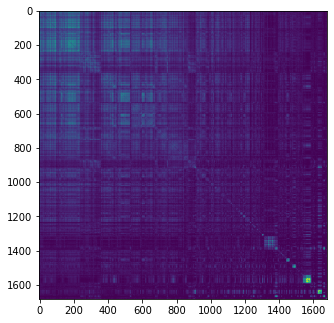

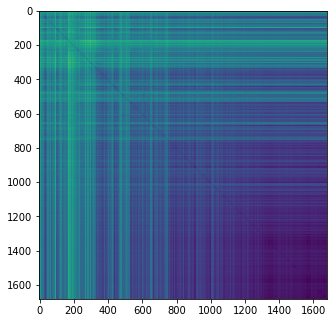

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure()
axes = fig.add_axes([1,1,1,1])
axes.imshow(D)
fig2 = plt.figure()
axes2 = fig2.add_axes([1,1,1,1])
axes2.imshow(D2)

In [9]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(R, test_size=0.05)

D=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(train.T, metric='cosine'))
D=np.abs(np.nan_to_num(D-1)) #dist to similarity 
np.fill_diagonal(D,0) #set self-dist to zero

D2=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(train.T, metric='euclidean'))
D2=np.abs(np.nan_to_num(D2-1)) #dist to similarity 
np.fill_diagonal(D2,0) #set self-dist to zero

In [10]:
print(np.mean(test_Score(D,test)))
print(np.mean(test_Score(D2,test)))

2.2941666666666665
1.593333333333333


## 4.2 Baseline Results
Implement and compare results of
* random recommendations
* allways recommending the top 5 movies (over all users)

In [17]:
def test_Score_random(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID_random(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

def Score_byID_random(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getRandomN(D)[::-1]
    res_title = getNameByID(getRandomN(D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)

def getRandomN(D, N=50):
    return np.random.randint(np.shape(D)[0], size=N)

def test_Score_top_5(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID_top_5(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

def Score_byID_top_5(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTop5(D)[::-1]
    res_title = getNameByID(getTop5(D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)

def getTop5(D):
    t = np.sum(D,axis=0)
    return np.argsort(t)[-5:]

In [18]:
print(np.mean(test_Score_random(D,test)))
print(np.mean(test_Score_top_5(D,test)))

0.27166666666666667
1.55


## 4.3 SVD
Implement the SVD approach. Hints: 
* use numpy.linalg.svd()
* apply SVD on $R$
* plot the singular values and decide where to cut off the reconstruction
* reconstruct R and evaluate $R'$
* compute the distance between two movies using $R'$


In [20]:
u, s, vh = np.linalg.svd(train)

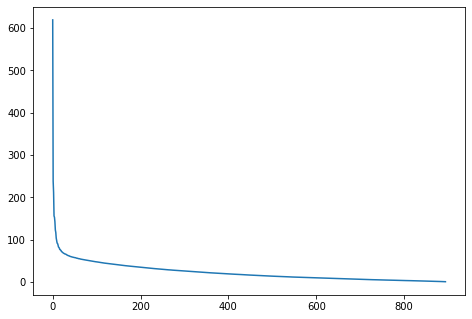

In [21]:
fig = plt.figure()
axes = fig.add_axes([1,1,1,1])
axes.plot(s)

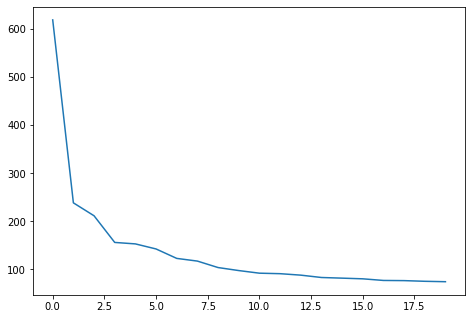

In [32]:
fig = plt.figure()
axes = fig.add_axes([1,1,1,1])
axes.plot(s[:20])

In [ ]:
#cut off at 5

In [36]:
R_new = np.dot(u[:,:5] * s[:5], vh[:5,:])

In [37]:
D_new=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R_new.T, metric='cosine'))
D_new=np.abs(np.nan_to_num(D_new-1)) #dist to similarity 
np.fill_diagonal(D_new,0) #set self-dist to zero

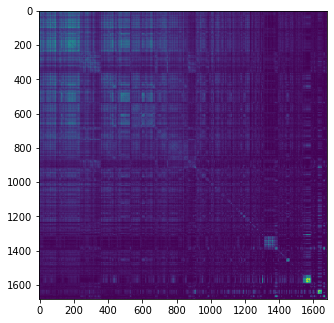

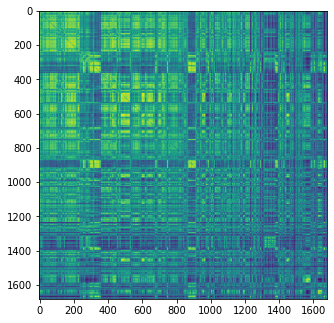

In [38]:
fig = plt.figure()
axes = fig.add_axes([1,1,1,1])
axes.imshow(D)
fig2 = plt.figure()
axes2 = fig2.add_axes([1,1,1,1])
axes2.imshow(D_new)

In [41]:
print(np.mean(test_Score(D,test)))
print(np.mean(test_Score(D_new,test)))

2.2941666666666665
1.2191666666666665
